# Globals

In [18]:
startNet = ''
saveNetAs = 'start'
saveResultsAs = 'start.npy'
loadNet = 'start'
loadResult = 'start.npy'
saveTestAs = 'test.npy'
loadTest = 'test.npy'
valid_ratio = 0.3
batchSize = 512
numEpochs = 20
rangeEpochs = 10
learningRates = [0.0001, 0.001, 0.01]

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

import os
oriPATH = 'C:/Users/Ryan/Desktop/machine-learning/part2/cnn'
task = '/final'
subFolder = '/round3'
if not os.path.exists(oriPATH + task):
    os.makedirs(oriPATH + task)
PATH = oriPATH + task + subFolder
if not os.path.exists(PATH):
    os.makedirs(PATH)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

cuda:0


# Define CNN

In [19]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.lossFunction = nn.CrossEntropyLoss()
        self.act = nn.SELU()

        self.conv1 = nn.Conv2d(3, 48, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # self.norm1 = nn.BatchNorm2d(96)
        self.conv2 = nn.Conv2d(48, 96, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(96, 192, kernel_size=3, stride=1, padding=1)
        # self.norm2 = nn.BatchNorm2d(192)
        self.conv4 = nn.Conv2d(192, 192, kernel_size=3, stride=1, padding=1)
        self.drop1 = nn.AlphaDropout(p=0.1)
        self.fc1 = nn.Linear(192 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.pool(self.act(self.conv1(x)))
        x = self.act(self.conv2(x))
        x = self.drop1(x)
        # x = self.norm1(x)
        x = self.pool(self.act(self.conv3(x)))
        # x = self.norm2(x)
        x = self.act(self.conv4(x))
        x = self.drop1(x)
        x = x.view(-1, 192 * 8 * 8)
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        x = self.fc4(x)
        return x


    def procBatch(self, batch):
        data, labels = batch
        pred = self(data)
        return self.lossFunction(pred, labels)
    
    def save(self, PATH, fileName, epoch):
        torch.save(self.state_dict(), os.path.join(PATH, "{}_epoch_{}.pth".format(fileName, epoch)))

    def load(self, PATH, fileName):
        self.load_state_dict(torch.load(os.path.join(PATH, fileName)))

# CIFAR-10 Dataset and Augmentations

In [20]:
import torchvision
import torchvision.transforms as transforms

testTransform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=testTransform)
testLoader = torch.utils.data.DataLoader(testset, batch_size=batchSize, shuffle=True, num_workers=2, pin_memory=True)

Files already downloaded and verified


# Define Test Functions

In [21]:
import helper
import numpy as np

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
def testCNN(testloader, net, confusionMatrix):
    correct, total = 0, 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()
            c = (predicted == labels.to(device))
            if confusionMatrix:
                for i in range(len(c)):
                    label = labels[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1
    return correct, total

def eachAccuracy(testNet, numTests, mode):
    testNet.eval()
    accuracy = []
    for j in range(numTests):
        testNet.load(PATH, "{}_epoch_{}.pth".format(loadNet, j))
        correct, total = testCNN(testLoader, testNet, mode)
        accuracy.append(100 * correct / total)
    return accuracy

def manyAccuracies(accuracy, testNet, kind, optimizers, mode):
    for i in range(len(learningRates)):    
        temp = []
        newPath = PATH + "/{}_lr_{}".format(kind, optimizers[i].defaults['lr'])
        for j in range(numTests):
            fileName = "{}_epoch_{}_lr_{}.pth".format(kind, j, learningRates[i])
            testNet.load_state_dict(torch.load(OO.path.join(newPath, fileName)))
            correct, total = helper.testCNN(testLoader, testNet, mode)
            temp.append(100 * correct / total)
        accuracy.append(temp)

# Test and Store

In [22]:
testNet = Net()
testNet = testNet.to(device)

accuracy = eachAccuracy(testNet, numEpochs, False)

np.save(os.path.join(PATH, saveTestAs), accuracy)

# Graph Test Data

NameError: name 'result' is not defined

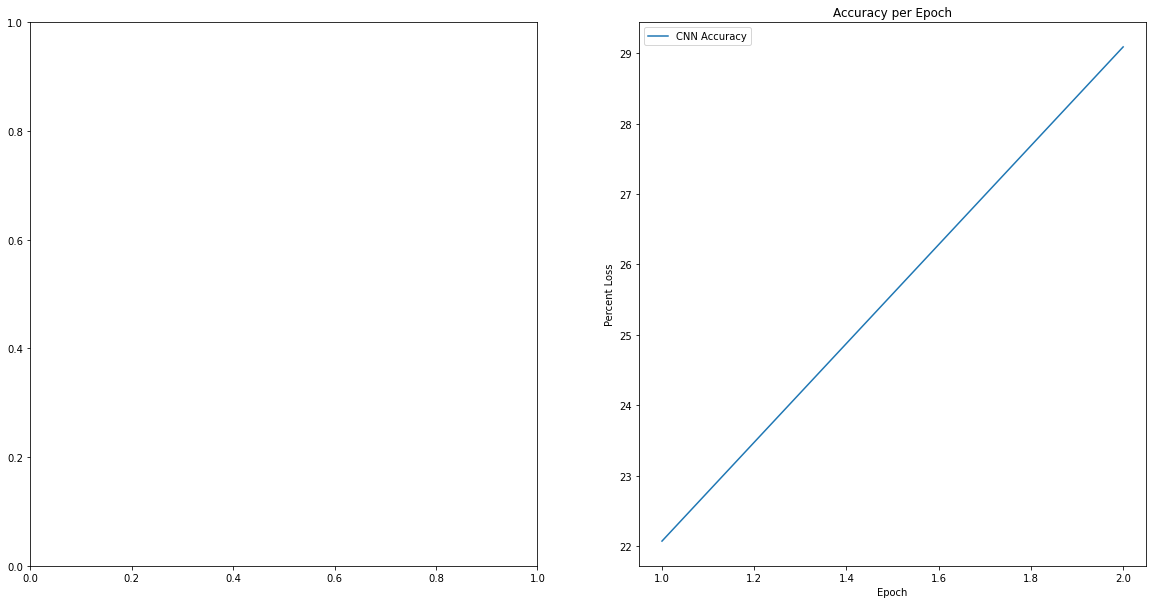

In [23]:
import matplotlib.pyplot as plt
import numpy as np



accuracy = np.load(os.path.join(PATH, loadTest), allow_pickle=True)

epochs = range(1, len(accuracy) + 1)
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20, 10)

ax[1].plot(epochs, accuracy, label='CNN Accuracy')
ax[1].legend(loc="upper left")
ax[1].set_title("Accuracy per Epoch")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Percent Loss")

# result = np.load(os.path.join(PATH, loadResult), allow_pickle=True)
training = [x['train'].item() for x in result]
validation = [x['valid'].item() for x in result]

ax[0].plot(epochs, training, label='train loss')
ax[0].plot(epochs, validation, label='validation loss')
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Percent Loss")
ax[0].legend(loc="lower left")
ax[0].set_title("Training and Validation Loss per Epoch")

